In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

In [2]:
AL_INSS_EMPREGADO = 0.11
AL_INSS_EMPREGADOR = 0.2
AL_IRPF = 0.275
AL_IRPJ = 0.15
AL_PIS = 0.0065
AL_COFINS = 0.03
AL_CSLL = 0.09
AL_ISS = 0.02
AL_DAS_3 = 0.06
AL_DAS_5 = 0.155
LUCRO_PRESUMIDO = 0.32
FATOR_R = 0.28
SALARIO_MINIMO = 1212.00
LIMITE_MEI_MENSAL = 6750.00
SUBLIMITE_SIMPLES = 3.6e6

In [3]:
# Tabelas de aliquotas
# Piso da faixa, aliquota, dedução
TABELA_IRPF = np.array(
    [
        [0, 0, 0],
        [1903.99, 0.075, 142.80],
        [2826.66, 0.15, 354.80],
        [3751.06, 0.225, 636.13],
        [4664.69, 0.275, 869.36],
    ]
)

TABELA_DAS_3 = np.array(
    [
        [0, 0.06, 0],
        [180000, 0.112, 9360],
        [360000, 0.135, 17640],
        [720000, 0.16, 35640],
        [1800000, 0.21, 125640],
        [3600000, 0.33, 648000],
        [4800000, np.nan, np.nan],
    ]
)

TABELA_DAS_5 = np.array(
    [
        [0, 0.155, 0],
        [180000, 0.18, 4500],
        [360000, 0.195, 9900],
        [720000, 0.205, 17100],
        [1800000, 0.23, 62100],
        [3600000, 0.305, 540000],
        [4800000, np.nan, np.nan],
    ]
)


In [4]:
def aplica_tabela(valor, tabela):
    for faixa in np.sort(tabela, axis=0)[::-1]:
        if valor > faixa[0]:
            return valor * faixa[1] - faixa[2]


aplica_tabela = np.vectorize(aplica_tabela, excluded=[1])

In [5]:
def INSS_empregado(salario_mensal):
    return AL_INSS_EMPREGADO * salario_mensal


def INSS_patronal(salario_mensal):
    return AL_INSS_EMPREGADOR * salario_mensal


def IRPF(salario_mensal):
    return aplica_tabela(salario_mensal, TABELA_IRPF)


def IRPJ(faturamento_mensal):
    return faturamento_mensal * AL_IRPJ + (faturamento_mensal >= 20000) * (faturamento_mensal - 20000) * 0.1


def PIS(faturamento_mensal):
    return AL_PIS * faturamento_mensal


def COFINS(faturamento_mensal):
    return AL_COFINS * faturamento_mensal


def CSLL(faturamento_mensal):
    return AL_CSLL * faturamento_mensal


def ISS(faturamento_mensal):
    return AL_ISS * faturamento_mensal


def DAS_3(faturamento_mensal):
    return aplica_tabela(faturamento_mensal * 12, TABELA_DAS_3) / 12


def DAS_5(faturamento_mensal):
    return aplica_tabela(faturamento_mensal * 12, TABELA_DAS_5) / 12

In [6]:
def lucro_presumido(faturamento_mensal):
    lucro = faturamento_mensal * LUCRO_PRESUMIDO
    pro_labore = SALARIO_MINIMO
    return (IRPJ(lucro)
        + CSLL(lucro)
        + PIS(faturamento_mensal)
        + COFINS(faturamento_mensal)
        + ISS(faturamento_mensal)
        + INSS_empregado(pro_labore)
        + INSS_patronal(pro_labore)
        + IRPF(pro_labore)
    )


def simples_3(faturamento_mensal):
    pro_labore = SALARIO_MINIMO
    return (DAS_3(faturamento_mensal)
        + INSS_empregado(pro_labore)
        + IRPF(pro_labore)
        + ISS(faturamento_mensal) * (faturamento_mensal > SUBLIMITE_SIMPLES / 12)
    )


def simples_5(faturamento_mensal):
    pro_labore = SALARIO_MINIMO
    return (DAS_5(faturamento_mensal)
        + INSS_empregado(pro_labore)
        + IRPF(pro_labore)
        + ISS(faturamento_mensal) * (faturamento_mensal > SUBLIMITE_SIMPLES / 12)
    )


def simples_35(faturamento_mensal):
    pro_labore = np.maximum(faturamento_mensal * FATOR_R, SALARIO_MINIMO)
    return (DAS_3(faturamento_mensal)
        + INSS_empregado(pro_labore)
        + IRPF(pro_labore)
        + ISS(faturamento_mensal) * (faturamento_mensal > SUBLIMITE_SIMPLES / 12)
    )

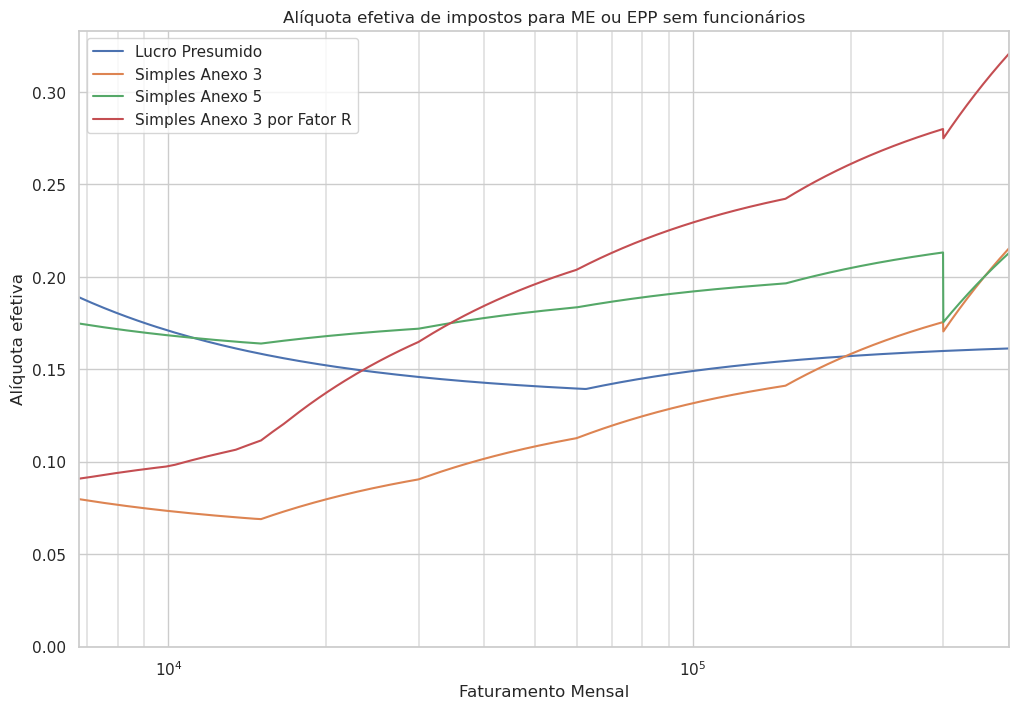

In [7]:
faturamento_mensal = np.linspace(LIMITE_MEI_MENSAL, 4.8e6/12, 1000)

plt.figure(figsize=(12, 8))
plt.title("Alíquota efetiva de impostos para ME ou EPP sem funcionários")
plt.plot(faturamento_mensal, lucro_presumido(faturamento_mensal) / faturamento_mensal, label="Lucro Presumido")
plt.plot(faturamento_mensal, simples_3(faturamento_mensal) / faturamento_mensal, label="Simples Anexo 3")
plt.plot(faturamento_mensal, simples_5(faturamento_mensal) / faturamento_mensal, label="Simples Anexo 5")
plt.plot(faturamento_mensal, simples_35(faturamento_mensal) / faturamento_mensal, label="Simples Anexo 3 por Fator R")
plt.xscale("log")
plt.ylim(bottom=0)
plt.xlim(left=LIMITE_MEI_MENSAL, right=4.8e6/12)
plt.minorticks_on()
plt.grid(which="minor", axis="x", linestyle="-", linewidth="0.15", color="black")
plt.xlabel("Faturamento Mensal")
plt.ylabel("Alíquota efetiva")
plt.legend()
plt.show()

